# binary classification example - titanic dataset

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import copy
import numpy as np
import pandas as pd
from pandas.testing import assert_frame_equal
from pandas.testing import assert_series_equal
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import treelite
import treelite_runtime
import dill
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
cmap = sns.color_palette("vlag", as_cmap=True)

**Gators** imports

In [5]:
# data cleaning
from gators.data_cleaning import (
    DropColumns,
    Replace,
)
# imputers
from gators.imputers import (
    NumericsImputer, 
    ObjectImputer,
)
# encoders
from gators.encoders import (
    WOEEncoder,
    TargetEncoder,
)
# binning
from gators.binning import (
    BinRareCategories,
    BinSingleTargetClassCategories,
    Binning,
    TreeBinning,
)
# feature generation
from gators.feature_generation import (
    ElementaryArithmetics,
    PolynomialObjectFeatures,
    IsNull,
)
from gators.feature_generation_str import (
    StringContains,
    StringLength,
    SplitExtract,
)
# feature selection
from gators.feature_selection import (
    InformationValue
)
# model building
from gators.model_building import (
    TrainTestSplit,
    XGBBoosterBuilder,
    XGBTreeliteDumper,
)
# pipeline
from gators.pipeline import Pipeline

In [6]:
data = pd.read_parquet('data/titanic.parquet')
data = data.reset_index(drop=True)
y = data['Survived']
X = data.drop('Survived', axis=1)
train_test_split = TrainTestSplit(test_ratio=0.3, strategy='stratified')
X_train, X_test, y_train, y_test = train_test_split.transform(X, y)

## data analysis

In [7]:
X_train.head(2)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
614,3,"Brocklebank, Mr. William Alfred",male,35.0,0,0,364512,8.0500,None,S
138,3,"Osen, Mr. Olaf Elon",male,16.0,0,0,7534,9.2167,None,S


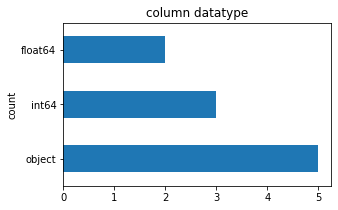

In [8]:
X_train.dtypes.value_counts().plot(
    figsize=(3*1.6, 3), 
    kind='barh', 
    title='column datatype',
    ylabel='dtype',
    xlabel='count',
);

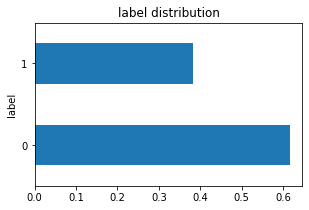

In [9]:
label_counts = data['Survived'].value_counts(normalize=True).sort_values().iloc[::-1]
label_counts.plot(
    kind='barh', 
    figsize=(3*1.6, 3), 
    title='label distribution',
    xlabel='label',
);

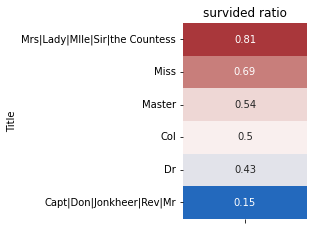

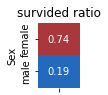

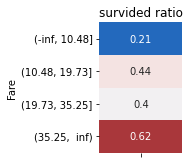

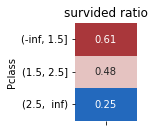

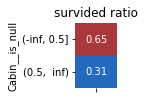

In [10]:
steps = [
    ('StringLength', StringLength(columns=['Ticket'])),
    ('SplitExtractName', SplitExtract(['Name'], [', '], [1], ['Dummy'])),
    ('SplitExtractTitle', SplitExtract(['Dummy'], ['.'], [0], ['Title'])),
    ('IsNull', IsNull(columns=['Age', 'Cabin'])),
    ('DropColumns', DropColumns(['Name',  'Dummy', 'Cabin', 'Ticket'])),
    ('ObjectImputer', ObjectImputer(strategy='constant', value='MISSING')),
    ('BinSingleTargetClassCategories', BinSingleTargetClassCategories()),
    ('NumericsImputer', NumericsImputer(strategy='mean')),
    ('ElementaryArithmetics', ElementaryArithmetics(
        operator='+',
        columns_a=['SibSp'], 
        columns_b=['Parch'], 
        column_names=['FamilySize'])),
    ('TreeBinning', TreeBinning(
        tree=DecisionTreeClassifier(max_depth=3, min_samples_leaf=120),
        inplace=True)),
    ('Encoder', TargetEncoder(add_missing_categories=False)),
]
pipe = Pipeline(steps=steps)
_ = pipe.fit(X_train.copy(), y_train)
_ = pipe.display_encoder_mapping(cmap=cmap, describe='survided ratio');

### adding polynomial object features

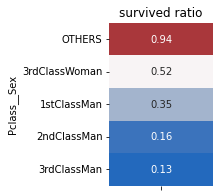

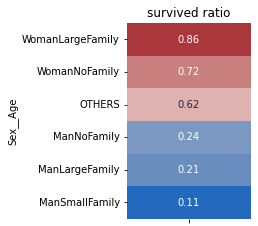

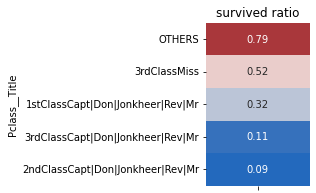

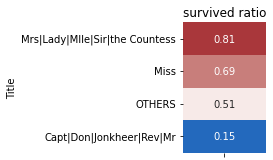

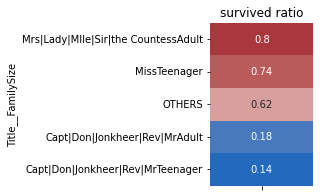

In [11]:
steps = [
    ('StringLength', StringLength(columns=['Ticket'])),
    ('SplitExtractName', SplitExtract(['Name'], [', '], [1], ['Dummy'])),
    ('SplitExtractTitle', SplitExtract(['Dummy'], ['.'], [0], ['Title'])),
    ('IsNull', IsNull(columns=['Age', 'Cabin'])),
    ('DropColumns', DropColumns(['Name',  'Dummy', 'Cabin', 'Ticket'])),
    ('ObjectImputer', ObjectImputer(strategy='constant', value='MISSING')),
    ('BinSingleTargetClassCategories', BinSingleTargetClassCategories()),
    ('NumericsImputer', NumericsImputer(strategy='mean')),
    ('ElementaryArithmetics', ElementaryArithmetics(
        operator='+',
        columns_a=['SibSp'], 
        columns_b=['Parch'], 
        column_names=['FamilySize'])),
    ('TreeBinning', TreeBinning(
        tree=DecisionTreeClassifier(max_depth=3, min_samples_leaf=120),
        inplace=True)),
    ('Replace', Replace(
        to_replace_dict={
            'Fare': {
                '_0': 'EconomicFare', 
                '_1': 'EconomicPlusFare', 
                '_2': 'BussinessFare', 
                '_3': 'FirstClassFare',},
            'Pclass': {'_0': '1stClass', '_1': '2ndClass', '_2': '3rdClass'},
            'Sex': {'female': 'Woman', 'male': 'Man'},
            'FamilySize': {'_0': 'Teenager', '_1': 'Adult', '_2': 'Senior'},
            'Age': {'_0': 'NoFamily', '_1': 'SmallFamily', '_2': 'LargeFamily'}
        }
    )),
    ('PolynomialObjectFeatures', PolynomialObjectFeatures(
        columns=['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Title', 'FamilySize'],
        degree=2)),
    ('DropPolynomialColumns', DropColumns(columns=['Sex__Title'])),
    ('CleanCategories', BinRareCategories(min_ratio=0.1)),
    ('Encoder', TargetEncoder(add_missing_categories=False)),
]
pipe = Pipeline(steps=steps)
_ = pipe.fit(X_train.copy(), y_train)
_ = pipe.display_encoder_mapping(cmap=cmap, decimals=2, describe='survived ratio')

## offline pipeline - feature selection

In [12]:
k = 12
model = XGBClassifier(
    random_state=0, 
    eval_metric='logloss', 
)
offline_steps = [
    ('StringLength', StringLength(columns=['Ticket'])),
    ('SplitExtractName', SplitExtract(['Name'], [', '], [1], ['Dummy'])),
    ('SplitExtractTitle', SplitExtract(['Dummy'], ['.'], [0], ['Title'])),
    ('IsNull', IsNull(columns=['Age', 'Cabin'])),
    ('DropColumns', DropColumns(['Name',  'Dummy', 'Cabin', 'Ticket'])),
    ('ObjectImputer', ObjectImputer(strategy='constant', value='MISSING')),
    ('BinSingleTargetClassCategories', BinSingleTargetClassCategories()),
    ('NumericsImputer', NumericsImputer(strategy='mean')),
    ('ElementaryArithmetics', ElementaryArithmetics(
        operator='+',
        columns_a=['SibSp'], 
        columns_b=['Parch'], 
        column_names=['FamilySize'])),
    ('TreeBinning', TreeBinning(
        tree=DecisionTreeClassifier(max_depth=3, min_samples_leaf=120),
        inplace=True)),
    ('CleanCategories', BinRareCategories(min_ratio=0.)),
    ('InformationValue', InformationValue(k=k)),
]
offline_pipe = Pipeline(steps=offline_steps)
X_train_prepro = offline_pipe.fit_transform(X_train.copy(), y_train)
features = list(X_train_prepro.columns)

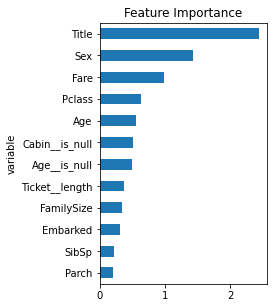

In [13]:
offline_pipe.steps[-1][1].feature_importances_.iloc[::-1].plot(
    kind='barh', 
    figsize=(3, 3*1.6), 
    title='Feature Importance',
);

All the features will be used.

## pipeline optimization

In [14]:
steps = [
    ('StringLength', StringLength(columns=['Ticket'])),
    ('SplitExtractName', SplitExtract(['Name'], [', '], [1], ['Dummy'])),
    ('SplitExtractTitle', SplitExtract(['Dummy'], ['.'], [0], ['Title'])),
    ('IsNull', IsNull(columns=['Age', 'Cabin'])),
    ('DropColumns', DropColumns(['Name',  'Dummy', 'Cabin', 'Ticket'])),
    ('ObjectImputer', ObjectImputer(strategy='constant', value='MISSING')),
    ('BinSingleTargetClassCategories', BinSingleTargetClassCategories()),
    ('NumericsImputer', NumericsImputer(strategy='mean', value=-1)),
    ('ElementaryArithmetics', ElementaryArithmetics(
        operator='+',
        columns_a=['SibSp'], 
        columns_b=['Parch'], 
        column_names=['FamilySize'])),
    ('TreeBinning', TreeBinning(
        tree=DecisionTreeClassifier(max_depth=2, min_samples_leaf=120),
        inplace=True)),
    ('PolynomialObjectFeatures', PolynomialObjectFeatures(
        columns=['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Title', 'FamilySize'],
        degree=2)),
    ('CleanCategories', BinRareCategories(min_ratio=0.1)),
    ('Encoder', WOEEncoder()),
    ('ESTIMATOR', XGBClassifier(random_state=0, eval_metric='logloss', use_label_encoder=False))
]


param_distributions = {
    "NumericsImputer__strategy": ["mean", "most_frequent", "constant"],
    "TreeBinning__tree": [
        DecisionTreeClassifier(
            max_depth=2, 
            min_samples_leaf=25, 
            random_state=0),
        DecisionTreeClassifier(
            max_depth=2, 
            min_samples_leaf=50, 
            random_state=0),
        DecisionTreeClassifier(
            max_depth=2, 
            min_samples_leaf=100, 
            random_state=0),
        DecisionTreeClassifier(
            max_depth=2, 
            min_samples_leaf=150, 
            random_state=0),
    ],
    "CleanCategories__min_ratio": [0, 0.1, 0.2],
    'ESTIMATOR__max_depth': [3, 4, 5],
    'ESTIMATOR__subsample': [0.4, 0.6, .8],
    'ESTIMATOR__colsample_bytree': [0.4, 0.6, .8],
    'ESTIMATOR__colsample_bylevel': [0.4, 0.6, .8],
    'ESTIMATOR__min_child_weight': [10, 20, 30],
}
def f1_score(y_true, y_pred):
    p = y_true[y_pred == 1].mean()
    r = y_pred[y_true == 1].mean()
    if (p == 0) | (r == 0):
        return 0
    return 2 * p * r / (p + r)
f1_scoring = make_scorer(f1_score)

from sklearn.metrics import log_loss

cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
search = RandomizedSearchCV(
    Pipeline(steps=steps),
    param_distributions=param_distributions, 
    n_iter=30,
    cv=cv,
    scoring=f1_scoring,
    n_jobs=-1,
    random_state=0,
    verbose=True)
_ = search.fit(X_train.copy(), y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


## model evaluation

In [15]:
thresholds = np.linspace(0, 1, 25)[1:-1]
y_train_pred_proba = search.best_estimator_.predict_proba(X_train.copy())[:, 1]
y_test_pred_proba = search.best_estimator_.predict_proba(X_test.copy())[:, 1]
fscores_train = [f1_score(y_train, y_train_pred_proba > t) for t in thresholds]
fscores_test = [f1_score(y_test, y_test_pred_proba > t) for t in thresholds]
print(f'MAX F1-score test set: {max(fscores_test):.2f}')

MAX F1-score test set: 0.80


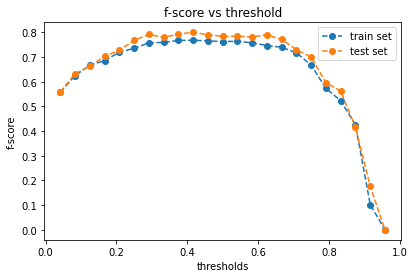

In [16]:
fig, ax = plt.subplots(figsize=[4 *1.6, 4]);
_ = plt.plot(thresholds, fscores_train, '--o', label='train set');
_ = plt.plot(thresholds, fscores_test, '--o', label='test set');
_ = plt.title('f-score vs threshold');
_ = plt.xlabel('thresholds');
_ = plt.ylabel('f-score');
_ = plt.legend()

## production pipeline & model

In [17]:
prod_pipe = copy.deepcopy(search.best_estimator_)
_ = prod_pipe.steps.pop(-1)
model_pd = copy.deepcopy(search.best_estimator_.steps[-1][1])

In [18]:
X_train_prepro_np = prod_pipe.transform_numpy(X_train.copy().to_numpy())
y_train_np = y_train.to_numpy()

xgb_booster = XGBBoosterBuilder.train(
    model=model_pd, 
    X_train=X_train_prepro_np, 
    y_train=y_train.to_numpy(),
)

treelite_model = treelite.Model.from_xgboost(xgb_booster)
treelite_model.export_lib(
    toolchain='gcc', 
    libpath='./models/treelite_xgb_titanic.so', 
    params={'parallel_comp': 4},
    verbose=True
)
model_prod = treelite_runtime.Predictor(
    './models/treelite_xgb_titanic.so', verbose=False)

[06:10:54] /Users/travis/build/dmlc/treelite/src/compiler/ast_native.cc:711: Using ASTNativeCompiler
[06:10:54] /Users/travis/build/dmlc/treelite/src/compiler/ast/split.cc:29: Parallel compilation enabled; member trees will be divided into 4 translation units.
[06:10:54] /Users/travis/build/dmlc/treelite/src/c_api/c_api.cc:92: Code generation finished. Writing code to files...
[06:10:54] /Users/travis/build/dmlc/treelite/src/c_api/c_api.cc:97: Writing file recipe.json...
[06:10:54] /Users/travis/build/dmlc/treelite/src/c_api/c_api.cc:97: Writing file tu3.c...
[06:10:54] /Users/travis/build/dmlc/treelite/src/c_api/c_api.cc:97: Writing file tu2.c...
[06:10:54] /Users/travis/build/dmlc/treelite/src/c_api/c_api.cc:97: Writing file tu1.c...
[06:10:54] /Users/travis/build/dmlc/treelite/src/c_api/c_api.cc:97: Writing file tu0.c...
[06:10:54] /Users/travis/build/dmlc/treelite/src/c_api/c_api.cc:97: Writing file header.h...
[06:10:54] /Users/travis/build/dmlc/treelite/src/c_api/c_api.cc:97: Wri

### check if Pandas & Treelite predictions match

In [19]:
X_test_np = X_test.to_numpy()
y_pred_pd = model_pd.predict_proba(
    prod_pipe.transform(X_test.copy()))[:, 1]
y_pred_tl = model_prod.predict(
    treelite_runtime.DMatrix(
        prod_pipe.transform_numpy(
            X_test_np.copy()
        )
    )
)
assert np.allclose(y_pred_pd, y_pred_tl)

## per-sample bechmarking

### pipeline only

In [20]:
x = X_test.iloc[[0]]
x_np = x.to_numpy()
stats_pd = %timeit -o prod_pipe.transform(x)
stats_np = %timeit -o prod_pipe.transform_numpy(x_np.copy())

69.9 ms ± 4.11 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
76.2 µs ± 3.81 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [21]:
speedup = 1e3 * float(str(stats_pd).split(' ')[0]) / float(str(stats_np).split(' ')[0])
f'Speed-up Pandas VS Numpy x{round(speedup)}'

'Speed-up Pandas VS Numpy x917'

### pipeline & model

In [22]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [23]:
stats_pd = %timeit -o model_pd.predict(prod_pipe.transform(x))[0]
stats_tl = %timeit -o  model_prod.predict(treelite_runtime.DMatrix(prod_pipe.transform_numpy(x_np.copy())))

113 ms ± 8.48 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
148 µs ± 5.12 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [24]:
speedup = 1e3 * float(str(stats_pd).split(' ')[0]) / float(str(stats_tl).split(' ')[0])
f'Speed-up Pandas VS Numpy&Treelite x{round(speedup)}'

'Speed-up Pandas VS Numpy&Treelite x764'